### Hotel Star Ratings: Model vs. the Expert

We take the first hundred images from google for the search term:
    
    "<S> star hotel"  where <S> is a number 1 to 5
    
We train a simple resnet34 on these images to build the model.

Next we construct a "quiz" where an expert iin the hotel industry predicts the number of stars from the picture. (note: the expert is unaware of the experimental setup)

We find on the metric of MSE on target-variable=number-of-stars(1 to 5) the model slightly outperforms the expert.

Note: the experimental setup is very crude, "1 star hotel" google search tends to emphasize camera-phone pictures of messy beds, while "5 star hotel" google search emphasizes artist-rendering / filtered photo of the exterior of the building. Interestingly, a major feature for "3 star hotels" that the model finds is the presence of heavy cloth curtains. 

Also the idea of star rating is a weird target variable: it's categorical, ordinal, but not really cardinal. The evaluation metrics should reflect this but they do not.

In [49]:
from fastai.vision import *
import random, os, sys, copy

#### Re-setup worksapce and import pre-built model

In [3]:
path = Path('data/hotels')
classes = ['1star', '2star', '3star', '4star', '5star']

def num_imgs():
    for _class in classes:
        print(_class, ':  ', len(os.listdir(path/_class)) )
num_imgs()

1star :   95
2star :   99
3star :   99
4star :   95
5star :   99


In [4]:
np.random.seed(42)

data = ImageDataBunch.from_folder(
                path, 
                train=".", 
                valid_pct=0.2,
                ds_tfms=get_transforms(), 
                size=224, 
                num_workers=4
        ).normalize(imagenet_stats)

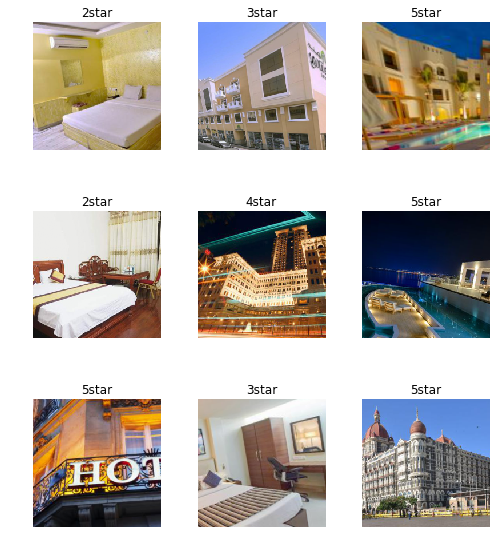

In [46]:
data.show_batch(rows=3, figsize=(7,8))

In [22]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
model_fn = 'hotels-stage-1-epoch10'
_ = learn.load(model_fn)

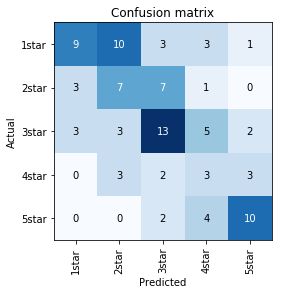

In [24]:
# verify loaded model has same characteristics
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [30]:
# confirmed: 26 1-star actuals in validation split, 
# which matches the confusion matirx plot.
# therefore data.valid_dl.y.items is ground-truth 
my_valids = data.valid_dl.y.items
my_valids = list(my_valids)
my_valids
valid0 = [e for e in my_valids if e ==0]
len(valid0)

26

In [60]:
# [ ] convert to a cpu model first
defaults.device = torch.device('cpu')
learn.export()

In [ ]:
#learn = load_learner(path)

#### Build Quiz-Answers & Quiz-Ground-Truth

In [9]:
# random inds on validation set; previously generated
# with random.sample() but seed not saved!
rand_inds = [67, 86, 66, 75, 79, 59, 49, 7, 70, 
             17, 25, 50, 18, 8, 15, 4, 83, 87, 
             71, 80, 27, 3, 76, 58, 22]

Quiz of 25 randomly selected hotel images in the validation set.

Quiz here: https://docs.google.com/document/d/1kZ-MpTre8xRBFaZ1Nn3QY12ATlw9y1TyX4oLEz6cWG0/edit

In [10]:
bri_answers = """
ind:  67  ;stars= 2 
ind:  86  ;stars= 3
ind:  66  ;stars=  2
ind:  75  ;stars= 4
ind:  79  ;stars= 4
ind:  59  ;stars= 5
ind:  49  ;stars= 3
ind:  7  ;stars= 5
ind:  70  ;stars= 4
ind:  17  ;stars= 3
ind:  25  ;stars= 4
ind:  50  ;stars= 2
ind:  18  ;stars= 2
ind:  8  ;stars= 4
ind:  15  ;stars= 2
ind:  4  ;stars= 3
ind:  83  ;stars= 4
ind:  87  ;stars= 5
ind:  71  ;stars= 4
ind:  80  ;stars= 2
ind:  27  ;stars= 3
ind:  3  ;stars= 2
ind:  76  ;stars= 4
ind:  58  ;stars= 3
ind:  22  ;stars= 3
"""

lines = bri_answers.split('\n')
lines = [l for l in lines if len(l.split(' ')) > 1 ]
lines = [l.strip() for l in lines]

expert = [l[-1] for l in lines]
len(expert),expert[:3]

(25, ['2', '3', '2'])

##### we will compare *quiz_y* (the expert's predictions) vs *quiz_truth* (the ground truth)

In [11]:
#note: expert scores on scale 1-5; models enums 0-4
quiz_y = [int(x) - 1 for x in expert]
quiz_y[:3]

[1, 2, 1]

In [13]:
# reproduce the validation inds ground truth
quiz_truth = [data.valid_dl.y.items[ind]
              for ind in rand_inds]
quiz_truth[:3]

[2, 4, 1]

#### Compare model perf to expert perf

In [18]:
def mse(y, yhat):
    diff = [(_y - _yhat) for _y, _yhat in zip(y, yhat)]
    sq_diff = [e**2 for e in diff]
    return sum(sq_diff) / len(sq_diff)
        

In [31]:
expert_mse = mse(quiz_truth, quiz_y)
expert_mse

1.56

In [35]:
quiz_x = [data.valid_dl.x.items[i] for i in rand_inds]

In [42]:
model_yhat = []
for _x in quiz_x:
    _img = open_image(_x)
    _output = learn.predict(_img)
    model_yhat.append(int(_output[1]))

len(model_yhat)

25

In [44]:
model_mse = mse(quiz_y, model_yhat)
model_mse

1.4

### Results --------------------------
model_mse (1.4) is lower than expert_mse (1.56) !

#### What other metrics can we evaluate on?

In [57]:
# custom function to build confusion plots
    
def conf_plot(yhat, quiz_truth):
    ''' input yhat, either model or expert, and then ground truth
        on a scale of 0-4
    '''
    tbl = []
    for _actual in range(5):

        ind_actuals = [_i for _i, _truth in enumerate(quiz_truth) 
                             if _truth == _actual]

        row = []
        for _predicted in range(5):

            x = [yhat[_ind] for _ind in ind_actuals 
                              if yhat[_ind] == _predicted]

            row.append(len(x))

        tbl.append(copy.copy(row))
    
    return copy.deepcopy(tbl)

In [53]:
cm_model = conf_plot(model_yhat, quiz_truth)
cm_expert = conf_plot(quiz_y, quiz_truth)

In [54]:
cm_model

[[1, 4, 1, 1, 0],
 [0, 2, 2, 0, 0],
 [1, 0, 5, 0, 0],
 [0, 1, 0, 1, 0],
 [0, 0, 1, 3, 2]]

In [55]:
cm_expert

[[0, 4, 2, 1, 0],
 [0, 2, 1, 1, 0],
 [0, 1, 2, 3, 0],
 [0, 0, 0, 2, 0],
 [0, 0, 2, 1, 3]]

### Model idiosyncrasies

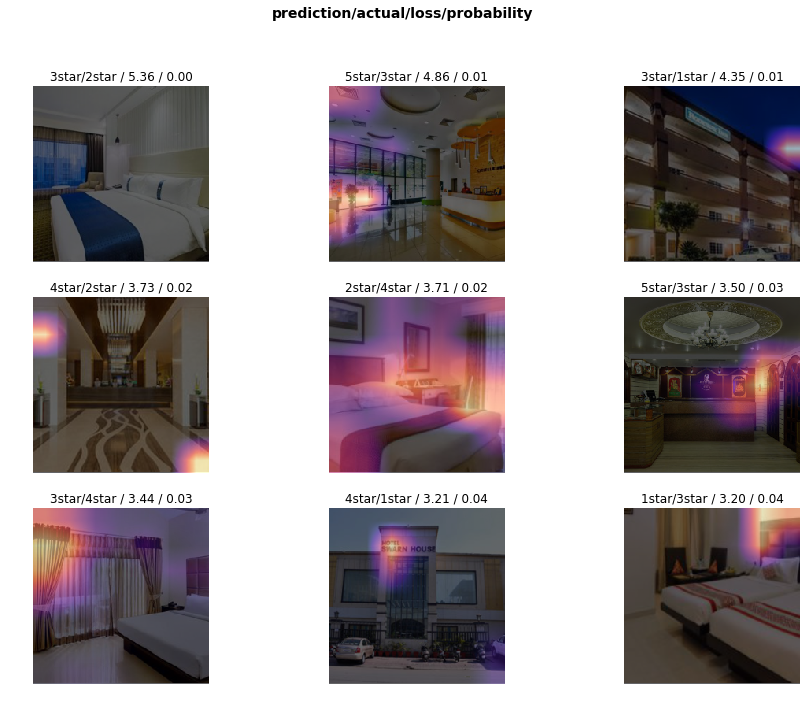

In [58]:
interp.plot_top_losses(9, figsize=(15,11))

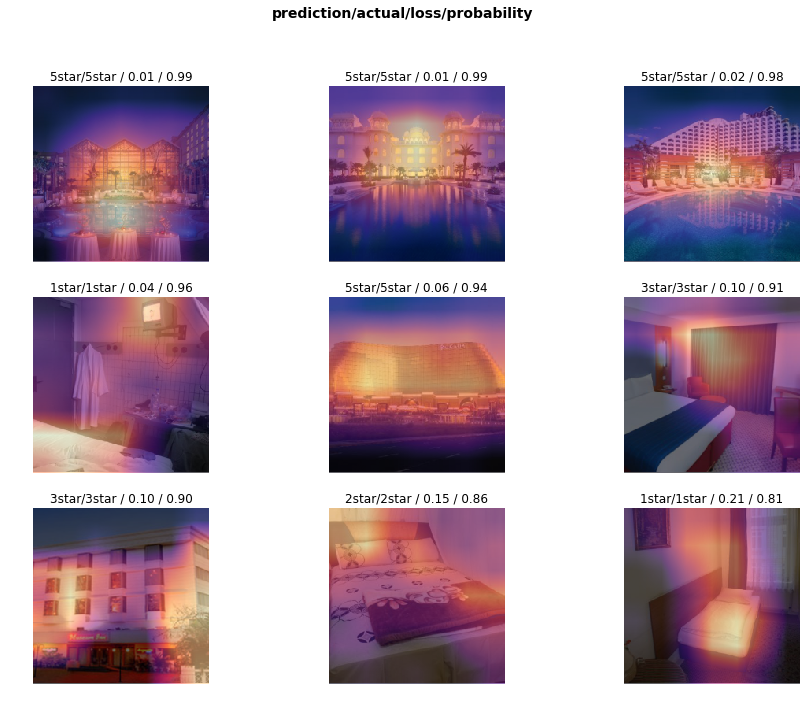

In [59]:
interp.plot_top_losses(9, figsize=(15,11), largest=False)

#### Trying to understand what the model is looking-at / deciding-on

Some features / patterns the model appears to learn:

3-star: has folded cloth curtains - see top_losses(largest=True)-image in column1, row3.

5-star: has lots of contiguous glass windows

1-star: the bedding only has white sheets; also, has a visible text sign (if exterior)

### Previous work: how to build the quiz

run the following cell, select all content in output with cursor, copy, then paste into a blank google docs

ind:  67  ;stars=


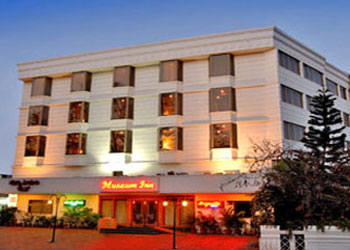

ind:  86  ;stars=


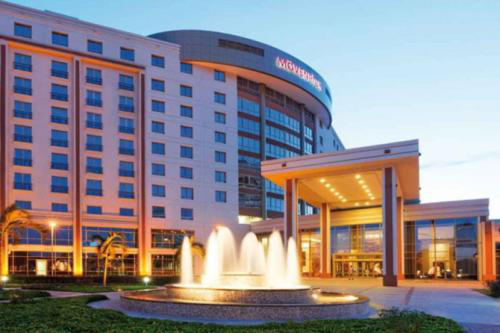

ind:  66  ;stars=


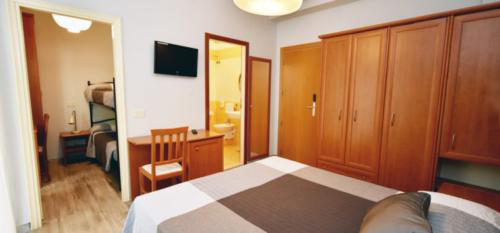

ind:  75  ;stars=


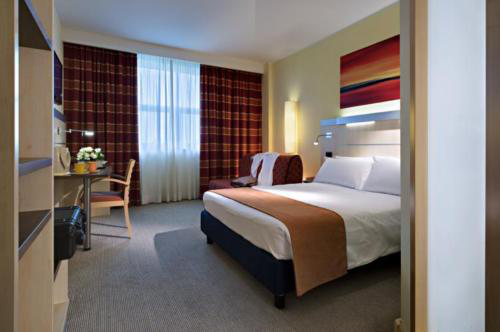

ind:  79  ;stars=


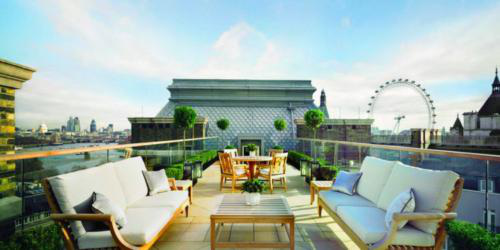

ind:  59  ;stars=


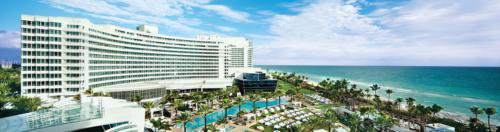

ind:  49  ;stars=


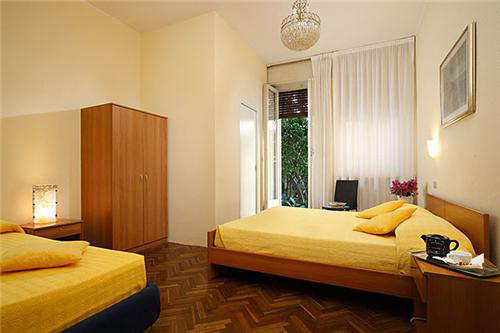

ind:  7  ;stars=


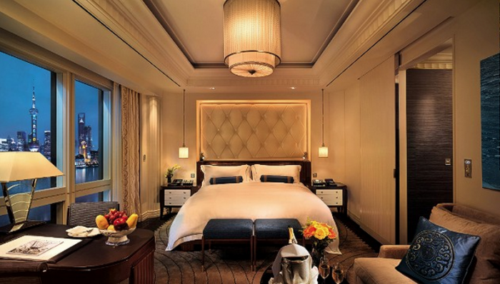

ind:  70  ;stars=


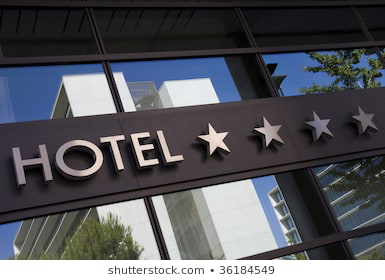

ind:  17  ;stars=


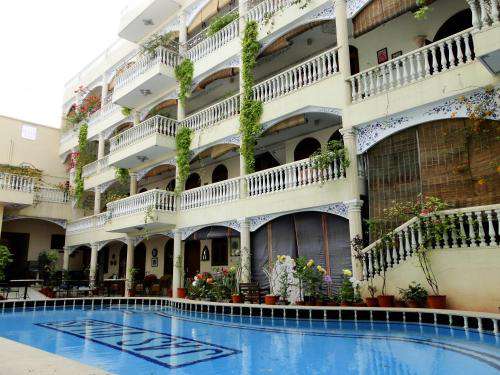

ind:  25  ;stars=


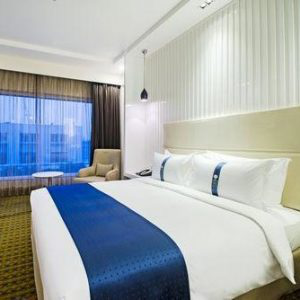

ind:  50  ;stars=


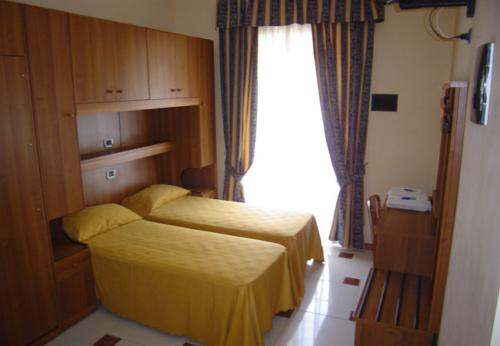

ind:  18  ;stars=


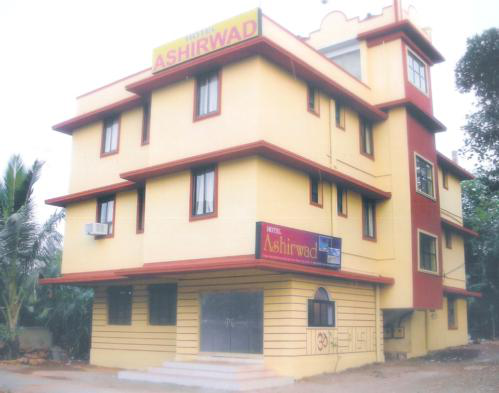

ind:  8  ;stars=


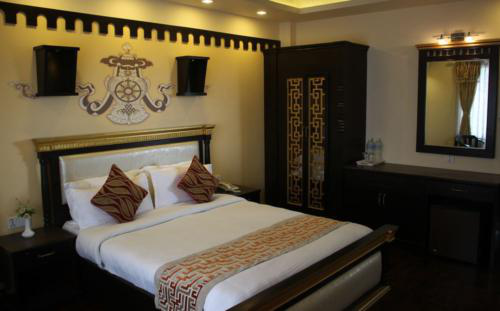

ind:  15  ;stars=


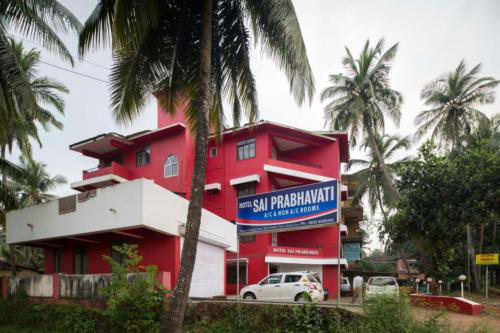

ind:  4  ;stars=


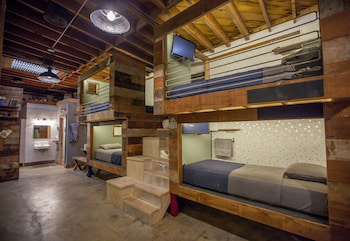

ind:  83  ;stars=


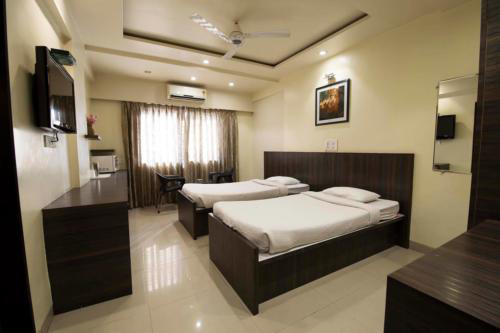

ind:  87  ;stars=


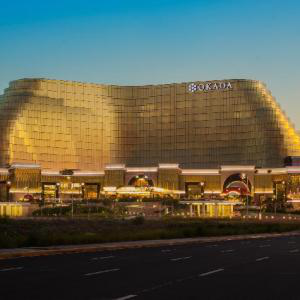

ind:  71  ;stars=


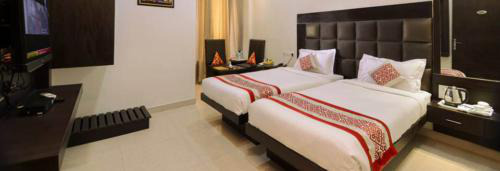

ind:  80  ;stars=


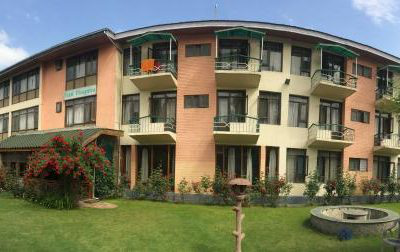

ind:  27  ;stars=


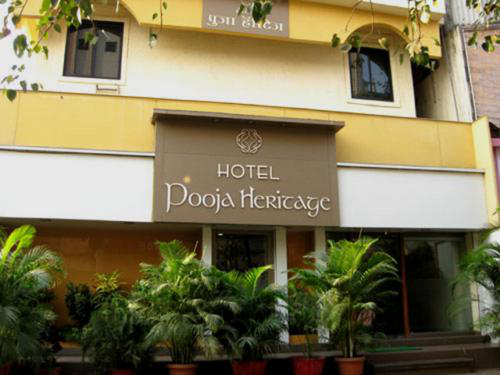

ind:  3  ;stars=


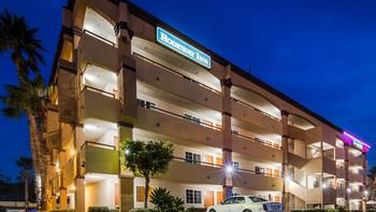

ind:  76  ;stars=


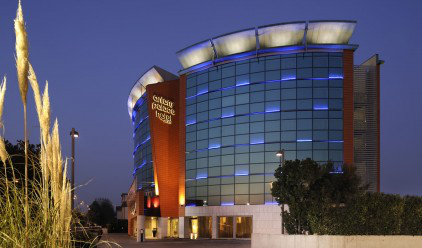

ind:  58  ;stars=


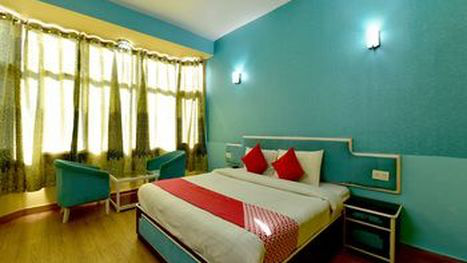

ind:  22  ;stars=


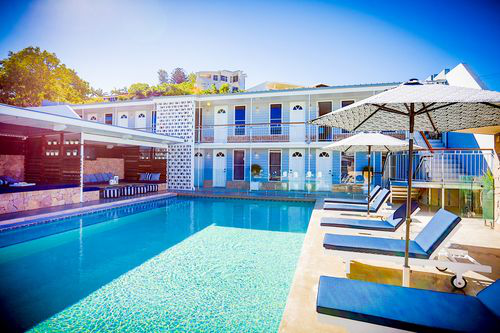

In [62]:
rand_inds = [67, 86, 66, 75, 79, 59, 49, 7, 70, 
             17, 25, 50, 18, 8, 15, 4, 83, 87, 
             71, 80, 27, 3, 76, 58, 22]


for i in rand_inds:
    
    _imgPath = data.valid_dl.x.items[i]
    _y = data.valid_dl.y.items[i]
    _img = open_image(_imgPath)
    
    #turn this on for generating answers
#     print('ind: ', str(i), ' ;stars=', str(_y))
    #turn this on generating quiz
    print('ind: ', str(i), ' ;stars=',)
    
    display(_img)